<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Step-1:-Load-the-Data/Filtering-for-Chosen-Zipcodes" data-toc-modified-id="Step-1:-Load-the-Data/Filtering-for-Chosen-Zipcodes-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Step 1: Load the Data/Filtering for Chosen Zipcodes</a></span></li><li><span><a href="#Step-2:-Data-Preprocessing" data-toc-modified-id="Step-2:-Data-Preprocessing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Step 2: Data Preprocessing</a></span></li><li><span><a href="#Step-3:-EDA-and-Visualization" data-toc-modified-id="Step-3:-EDA-and-Visualization-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Step 3: EDA and Visualization</a></span></li><li><span><a href="#Step-4:-Reshape-from-Wide-to-Long-Format" data-toc-modified-id="Step-4:-Reshape-from-Wide-to-Long-Format-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Step 4: Reshape from Wide to Long Format</a></span></li><li><span><a href="#Step-5:-SARIMAX-Modeling" data-toc-modified-id="Step-5:-SARIMAX-Modeling-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Step 5: SARIMAX Modeling</a></span><ul class="toc-item"><li><span><a href="#Select-Best-Parameters" data-toc-modified-id="Select-Best-Parameters-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Select Best Parameters</a></span></li><li><span><a href="#Calculate-RMSE-for-West-Hollywood" data-toc-modified-id="Calculate-RMSE-for-West-Hollywood-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Calculate RMSE for West Hollywood</a></span></li></ul></li><li><span><a href="#Step-6:-Interpreting-Results" data-toc-modified-id="Step-6:-Interpreting-Results-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Step 6: Interpreting Results</a></span></li></ul></div>

# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import matplotlib
%matplotlib inline

import itertools
import statsmodels.api as sm

In [2]:
data = pd.read_csv('up_to_date_zillow_data.csv')
df = pd.DataFrame(data)

In [3]:
df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,...,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31
0,61639,0,10025,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,NaN,...,1416272.0,1409421.0,1407017.0,1412042.0,1414135.0,1415095.0,1408966.0,1401018.0,1389676.0,1384859.0
1,84654,1,60657,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,358776.0,...,957541.0,956310.0,954994.0,954985.0,956480.0,958337.0,959091.0,958959.0,958378.0,959519.0
2,61637,2,10023,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,NaN,...,1669612.0,1663472.0,1659302.0,1662263.0,1662774.0,1658055.0,1649411.0,1641047.0,1639442.0,1635311.0
3,91982,3,77494,Zip,TX,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,200271.0,...,335925.0,335929.0,336035.0,335760.0,335937.0,336360.0,337373.0,338225.0,338713.0,338889.0
4,84616,4,60614,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,540023.0,...,1187731.0,1185049.0,1183037.0,1182915.0,1185225.0,1187244.0,1188570.0,1188375.0,1189551.0,1192253.0


In [4]:
df_LA = df[df['City'] == 'Los Angeles']

# df_Austin = df[df['City'] == 'Austin']
# df_Austin = df_Austin[df_Austin['State'] == 'TX']

In [5]:
df_LA.sort_values(by='SizeRank', na_position='first')
#df_Austin.sort_values(by='SizeRank', na_position='first')

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,...,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31
43,96027,44,90046,Zip,CA,CA,Los Angeles,Los Angeles-Long Beach-Anaheim,Los Angeles County,177088.0,...,1843470.0,1853651.0,1868109.0,1880135.0,1900896.0,1918719.0,1936573.0,1948696.0,1963133.0,1982231.0
98,96015,99,90034,Zip,CA,CA,Los Angeles,Los Angeles-Long Beach-Anaheim,Los Angeles County,251418.0,...,1398417.0,1404092.0,1415063.0,1427241.0,1445321.0,1463208.0,1478076.0,1485024.0,1492268.0,1515853.0
114,96025,115,90044,Zip,CA,CA,Los Angeles,Los Angeles-Long Beach-Anaheim,Los Angeles County,126593.0,...,458596.0,461738.0,466106.0,470368.0,476367.0,482154.0,488178.0,492045.0,496175.0,502824.0
135,96007,136,90026,Zip,CA,CA,Los Angeles,Los Angeles-Long Beach-Anaheim,Los Angeles County,107147.0,...,985578.0,993267.0,1004494.0,1015062.0,1028334.0,1040727.0,1050599.0,1054837.0,1053531.0,1054874.0
172,96047,174,90066,Zip,CA,CA,Los Angeles,Los Angeles-Long Beach-Anaheim,Los Angeles County,237560.0,...,1489995.0,1493731.0,1501840.0,1513381.0,1534242.0,1552524.0,1569932.0,1579845.0,1593031.0,1624438.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10153,96058,10281,90077,Zip,CA,CA,Los Angeles,Los Angeles-Long Beach-Anaheim,Los Angeles County,507450.0,...,2941293.0,2957902.0,2976860.0,3001129.0,3030649.0,3058392.0,3069540.0,3067907.0,3060731.0,3062974.0
12492,95991,12671,90010,Zip,CA,CA,Los Angeles,Los Angeles-Long Beach-Anaheim,Los Angeles County,NaN,...,1704146.0,1676212.0,1642105.0,1618040.0,1615213.0,1626945.0,1633853.0,1633478.0,1636941.0,1656265.0
13698,96048,13909,90067,Zip,CA,CA,Los Angeles,Los Angeles-Long Beach-Anaheim,Los Angeles County,NaN,...,1384083.0,1382819.0,1385560.0,1387563.0,1390312.0,1393273.0,1399690.0,1403247.0,1404416.0,1414845.0
15910,96002,16223,90021,Zip,CA,CA,Los Angeles,Los Angeles-Long Beach-Anaheim,Los Angeles County,NaN,...,582944.0,587906.0,593058.0,598249.0,606264.0,612587.0,617230.0,619416.0,621052.0,628473.0


The top two in size rank are the West Hollywood and Palms neighborhoods. This makes sense as these are known to be very affluent neighborhoods in the Greater Los Angeles area. A less than 4,000 square foot penthouse apartment at the Edition on Sunset Blvd. in West Hollywood was listed on Zillow at $18.9M in 2020. 

The third ranked zipcode is in a pretty poor neighborhood. This makes me wonder if it is mostly multifamily units being sold here, which would increase the median home sale price for this zipcode. 

Next on the list is the zipcode containing Silverlake and Echo Park, which are popular hipster neighborhoods where some celebritites live and home to some very beautiful and nice homes. 

# Step 2: Data Preprocessing

I just checked and it looks like 'RegionName' is the zipcode and 'RegionID' is extra information that we don't need. So I will go ahead and drop that column.

In [6]:
df_LA = df_LA.drop(['RegionID','RegionType','SizeRank','StateName'], axis=1)
#df_Austin = df_Austin.drop(['RegionID','RegionType','SizeRank','StateName'], axis=1)

In [7]:
df_LA
#df_Austin

,RegionName,State,City,Metro,CountyName,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,...,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31
43,90046,CA,Los Angeles,Los Angeles-Long Beach-Anaheim,Los Angeles County,177088.0,177788.0,177914.0,178037.0,178157.0,...,1843470.0,1853651.0,1868109.0,1880135.0,1900896.0,1918719.0,1936573.0,1948696.0,1963133.0,1982231.0
98,90034,CA,Los Angeles,Los Angeles-Long Beach-Anaheim,Los Angeles County,251418.0,251855.0,251607.0,252109.0,252244.0,...,1398417.0,1404092.0,1415063.0,1427241.0,1445321.0,1463208.0,1478076.0,1485024.0,1492268.0,1515853.0
114,90044,CA,Los Angeles,Los Angeles-Long Beach-Anaheim,Los Angeles County,126593.0,126421.0,126441.0,126660.0,127097.0,...,458596.0,461738.0,466106.0,470368.0,476367.0,482154.0,488178.0,492045.0,496175.0,502824.0
135,90026,CA,Los Angeles,Los Angeles-Long Beach-Anaheim,Los Angeles County,107147.0,107706.0,108223.0,109044.0,109602.0,...,985578.0,993267.0,1004494.0,1015062.0,1028334.0,1040727.0,1050599.0,1054837.0,1053531.0,1054874.0
172,90066,CA,Los Angeles,Los Angeles-Long Beach-Anaheim,Los Angeles County,237560.0,238965.0,239626.0,241114.0,241992.0,...,1489995.0,1493731.0,1501840.0,1513381.0,1534242.0,1552524.0,1569932.0,1579845.0,1593031.0,1624438.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10153,90077,CA,Los Angeles,Los Angeles-Long Beach-Anaheim,Los Angeles County,507450.0,507983.0,508703.0,510189.0,511512.0,...,2941293.0,2957902.0,2976860.0,3001129.0,3030649.0,3058392.0,3069540.0,3067907.0,3060731.0,3062974.0
12492,90010,CA,Los Angeles,Los Angeles-Long Beach-Anaheim,Los Angeles County,NaN,NaN,NaN,NaN,NaN,...,1704146.0,1676212.0,1642105.0,1618040.0,1615213.0,1626945.0,1633853.0,1633478.0,1636941.0,1656265.0
13698,90067,CA,Los Angeles,Los Angeles-Long Beach-Anaheim,Los Angeles County,NaN,NaN,NaN,NaN,NaN,...,1384083.0,1382819.0,1385560.0,1387563.0,1390312.0,1393273.0,1399690.0,1403247.0,1404416.0,1414845.0
15910,90021,CA,Los Angeles,Los Angeles-Long Beach-Anaheim,Los Angeles County,NaN,213521.0,218175.0,222174.0,228082.0,...,582944.0,587906.0,593058.0,598249.0,606264.0,612587.0,617230.0,619416.0,621052.0,628473.0


In [8]:
def get_datetimes(df):
    return pd.to_datetime(df.columns.values[7:], format='%Y-%m')

In [9]:
get_datetimes(df_LA)
#get_datetimes(df_Austin)

DatetimeIndex(['1996-03-31', '1996-04-30', '1996-05-31', '1996-06-30',
               '1996-07-31', '1996-08-31', '1996-09-30', '1996-10-31',
               '1996-11-30', '1996-12-31',
               ...
               '2019-10-31', '2019-11-30', '2019-12-31', '2020-01-31',
               '2020-02-29', '2020-03-31', '2020-04-30', '2020-05-31',
               '2020-06-30', '2020-07-31'],
              dtype='datetime64[ns]', length=293, freq=None)

# Step 3: EDA and Visualization

In [10]:
# font = {'family' : 'normal',
#         'weight' : 'bold',
#         'size'   : 22}

# matplotlib.rc('font', **font)

# # NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

# Step 4: Reshape from Wide to Long Format

In [11]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted#.groupby('time').aggregate({'value':'mean'})

In [12]:
df_LA_melt = melt_data(df_LA)
# df_Austin_melt = melt_data(df_Austin)

In [13]:
df_LA_melt_sort = df_LA_melt.sort_values(by=['RegionName','time','value'])
# df_Austin_melt_sort = df_Austin_melt.sort_values(by=['RegionName','time','value'])

In [14]:
df_LA_melt_sort['RegionName'].nunique()
# df_Austin_melt_sort['RegionName'].nunique()

100

We can see there are 100 different zipcodes in our dataset for Los Angeles. 

In [15]:
len(df_LA_melt_sort)
# len(df_Austin_melt_sort)

28727

And for those 100 zipcodes we have 28,727 datapoints. That's a good amount, giving an average of about 287 data points per zip code. Some may have more than others. We can explore that more when we come to it. 

In [16]:
df_LA_melt_sort.asfreq('m').index
# df_Austin_melt_sort

DatetimeIndex([], dtype='datetime64[ns]', freq='M')

In [17]:
zipcodes = df_LA_melt_sort['RegionName'].unique()
# zipcodes = df_Austin_melt_sort['RegionName'].unique()

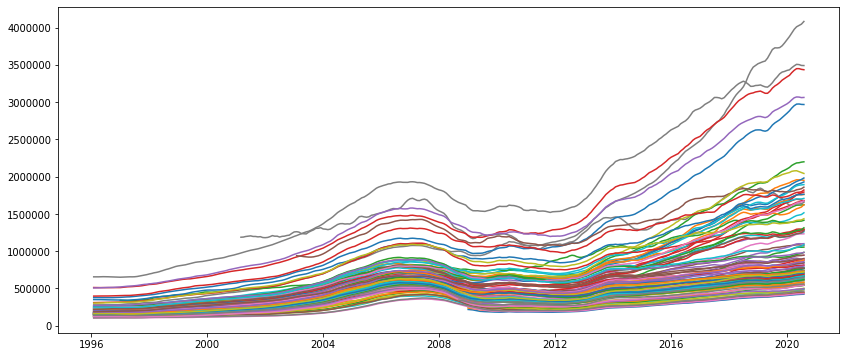

In [18]:
plt.figure(figsize=(14,6))
labels = []
for zipcode in zipcodes:
    df_zip = df_LA_melt_sort[df_LA_melt_sort['RegionName'] == zipcode]
    plt.plot(df_zip['time'],df_zip['value'], label=zipcode)
    labels.append(zipcode)

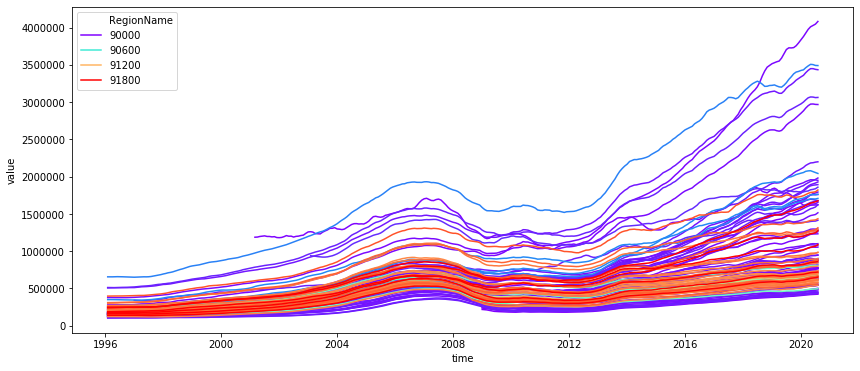

In [19]:
import seaborn as sns
plt.figure(figsize=(14,6))
sns.lineplot(x='time', y='value', data=df_LA_melt_sort, hue='RegionName', palette="rainbow");

**Zipcodes**

We can see a similar trend amongst all of our zipcodes. A few seem to be much higher than others, representing the more affluent neighborhoods. 

This data set represents median housing sale prices, so they could also include multifamily housing units as well, which would sell for a higher price than nearby single family homes. I imagine though overall the median would be representative and not skewed by this as density tends to be mixed (single family homes and multifamily homes), and sometimes in multifamily homes the individual apartments or condos are listed for sale individually. 

**Housing Bubble**

We can see the housing bubble of 2008 in the data here. Home sale values start increasing rapidly in 2004, then max out late 2006/early 2007 and begin to dip to a min in around 2009. Some zipcodes slowly drop even lower for the next couple of years. Prices slowly begin to recover, reaching max bubble values in about 2013, 6 years after the bubble burst. 

Since the market is volatile and bubbles are somewhat unpredictable and do occur, with another one being anticipated in 2020-2022, I am going to leave this data in the data set. 

# Step 5: SARIMAX Modeling

I conducted research and found that there is seasonality in home sales, so I am going to use SARIMA for my ARIMA Modeling, which integrates seasonality in the model. 

**Seasonality**

According to the National Association of Realtors, the number of home sales increases significantly in the spring, with home sales increasing by 34% in February and March. 

Sales continue upward with the busiest home selling months being May through August, accounting for 40% of United States annual home sales volume. 

The slowest months are November through February, with January being the slowest. 

Prices of homes slightly increase during surge months when the demand in the market is higher. Therefore selling homes during these peak times could prove to be advantageous for maximizing profits.

Reference: https://www.nar.realtor/blogs/economists-outlook/seasonality-in-the-housing-market

**Volatility**

A note about market volatility. Since the strategy we are focused on here is buy and hold, if and when there is a housing bubble, it is best to continue to hold during this time. While having a mortgage does create a liability, history shows that during a recession or related housing bubble, the rental market is not as affected as the housing market. 

Reference: https://www.forbes.com/sites/forbesrealestatecouncil/2020/01/02/how-will-a-recession-affect-my-rental-properties/#a4b70b45c70f

In [20]:
WeHo = df_LA_melt_sort[df_LA_melt_sort['RegionName'] == 90046]

In [21]:
WeHo.index = WeHo['time']

In [22]:
to_drop = ['RegionName','City','State','Metro','CountyName','time']
WeHo = WeHo.drop(to_drop, axis=1)
WeHo 

,value
time,
1996-01-31,177088.0
1996-02-29,177788.0
1996-03-31,177914.0
1996-04-30,178037.0
1996-05-31,178157.0
...,...
2020-03-31,1918719.0
2020-04-30,1936573.0
2020-05-31,1948696.0


## Select Best Parameters 

Select best parameters for p, d & q according to the lowest BIC value.

In [23]:
# Define the p, d and q parameters to take any value between 0 and 3
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [24]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best BIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(WeHo,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False,
                                            freq='M')

            output = mod.fit(maxiter=100) 
            ans.append([comb, combs, output.bic])
            print('SARIMAX {} x {}12 : BIC Calculated ={}'.format(comb, combs, output.bic))
        except:
            continue

SARIMAX (0, 0, 0) x (0, 0, 0, 12)12 : BIC Calculated =8872.04900513266
SARIMAX (0, 0, 0) x (0, 0, 1, 12)12 : BIC Calculated =8344.589010661477
SARIMAX (0, 0, 0) x (0, 0, 2, 12)12 : BIC Calculated =7984.746234386041
SARIMAX (0, 0, 0) x (0, 1, 0, 12)12 : BIC Calculated =7327.721808432406
SARIMAX (0, 0, 0) x (0, 1, 1, 12)12 : BIC Calculated =7032.85501878065
SARIMAX (0, 0, 0) x (0, 1, 2, 12)12 : BIC Calculated =6552.701058477384
SARIMAX (0, 0, 0) x (0, 2, 0, 12)12 : BIC Calculated =6620.497021219602
SARIMAX (0, 0, 0) x (0, 2, 1, 12)12 : BIC Calculated =6342.153815679646
SARIMAX (0, 0, 0) x (0, 2, 2, 12)12 : BIC Calculated =6054.134769937056
SARIMAX (0, 0, 0) x (1, 0, 0, 12)12 : BIC Calculated =6986.796145557303
SARIMAX (0, 0, 0) x (1, 0, 1, 12)12 : BIC Calculated =6926.532856763946
SARIMAX (0, 0, 0) x (1, 0, 2, 12)12 : BIC Calculated =6623.2125857853725
SARIMAX (0, 0, 0) x (1, 1, 0, 12)12 : BIC Calculated =6643.824828349578
SARIMAX (0, 0, 0) x (1, 1, 1, 12)12 : BIC Calculated =9421.459348

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (0, 0, 1) x (0, 0, 1, 12)12 : BIC Calculated =8235.240605104289
SARIMAX (0, 0, 1) x (0, 0, 2, 12)12 : BIC Calculated =7876.788065825364
SARIMAX (0, 0, 1) x (0, 1, 0, 12)12 : BIC Calculated =7403.237994462634
SARIMAX (0, 0, 1) x (0, 1, 1, 12)12 : BIC Calculated =6774.709942167926
SARIMAX (0, 0, 1) x (0, 1, 2, 12)12 : BIC Calculated =8822.922639848133
SARIMAX (0, 0, 1) x (0, 2, 0, 12)12 : BIC Calculated =6389.512378430427
SARIMAX (0, 0, 1) x (0, 2, 1, 12)12 : BIC Calculated =7803.270553758564
SARIMAX (0, 0, 1) x (0, 2, 2, 12)12 : BIC Calculated =5733.994099806426
SARIMAX (0, 0, 1) x (1, 0, 0, 12)12 : BIC Calculated =8894.674341278547
SARIMAX (0, 0, 1) x (1, 0, 1, 12)12 : BIC Calculated =8739.148771715723
SARIMAX (0, 0, 1) x (1, 0, 2, 12)12 : BIC Calculated =8132.922417246165
SARIMAX (0, 0, 1) x (1, 1, 0, 12)12 : BIC Calculated =6799.948951909064
SARIMAX (0, 0, 1) x (1, 1, 1, 12)12 : BIC Calculated =6755.213449848434
SARIMAX (0, 0, 1) x (1, 1, 2, 12)12 : BIC Calculated =8256.62444

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (0, 0, 2) x (1, 0, 2, 12)12 : BIC Calculated =55405.3323041519
SARIMAX (0, 0, 2) x (1, 1, 0, 12)12 : BIC Calculated =7153.652912594254
SARIMAX (0, 0, 2) x (1, 1, 1, 12)12 : BIC Calculated =6729.681702483568
SARIMAX (0, 0, 2) x (1, 1, 2, 12)12 : BIC Calculated =7853.915538953098
SARIMAX (0, 0, 2) x (1, 2, 0, 12)12 : BIC Calculated =6081.204339253752
SARIMAX (0, 0, 2) x (1, 2, 1, 12)12 : BIC Calculated =7188.73645426781
SARIMAX (0, 0, 2) x (1, 2, 2, 12)12 : BIC Calculated =6801.939862591695
SARIMAX (0, 0, 2) x (2, 0, 0, 12)12 : BIC Calculated =7936.06040536949
SARIMAX (0, 0, 2) x (2, 0, 1, 12)12 : BIC Calculated =125078148785.90459
SARIMAX (0, 0, 2) x (2, 0, 2, 12)12 : BIC Calculated =48964.43485061783
SARIMAX (0, 0, 2) x (2, 1, 0, 12)12 : BIC Calculated =6502.384362565502
SARIMAX (0, 0, 2) x (2, 1, 1, 12)12 : BIC Calculated =8512.630865249677
SARIMAX (0, 0, 2) x (2, 1, 2, 12)12 : BIC Calculated =8702.848554225848
SARIMAX (0, 0, 2) x (2, 2, 0, 12)12 : BIC Calculated =5802.6358152

SARIMAX (0, 2, 0) x (1, 2, 2, 12)12 : BIC Calculated =4853.443088822448
SARIMAX (0, 2, 0) x (2, 0, 0, 12)12 : BIC Calculated =4970.314860884542
SARIMAX (0, 2, 0) x (2, 0, 1, 12)12 : BIC Calculated =4972.46776619246
SARIMAX (0, 2, 0) x (2, 0, 2, 12)12 : BIC Calculated =4963.895498025365
SARIMAX (0, 2, 0) x (2, 1, 0, 12)12 : BIC Calculated =4941.429303967043
SARIMAX (0, 2, 0) x (2, 1, 1, 12)12 : BIC Calculated =4939.287747567856


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (0, 2, 0) x (2, 1, 2, 12)12 : BIC Calculated =4921.534582227953
SARIMAX (0, 2, 0) x (2, 2, 0, 12)12 : BIC Calculated =4916.725543635106
SARIMAX (0, 2, 0) x (2, 2, 1, 12)12 : BIC Calculated =4837.083503633337
SARIMAX (0, 2, 0) x (2, 2, 2, 12)12 : BIC Calculated =4808.555129148343
SARIMAX (0, 2, 1) x (0, 0, 0, 12)12 : BIC Calculated =5499.4137701898835
SARIMAX (0, 2, 1) x (0, 0, 1, 12)12 : BIC Calculated =5224.0702894533215
SARIMAX (0, 2, 1) x (0, 0, 2, 12)12 : BIC Calculated =4958.79804798092
SARIMAX (0, 2, 1) x (0, 1, 0, 12)12 : BIC Calculated =5583.249511339673
SARIMAX (0, 2, 1) x (0, 1, 1, 12)12 : BIC Calculated =5272.093964134965
SARIMAX (0, 2, 1) x (0, 1, 2, 12)12 : BIC Calculated =4927.382854081625
SARIMAX (0, 2, 1) x (0, 2, 0, 12)12 : BIC Calculated =5653.049306908438
SARIMAX (0, 2, 1) x (0, 2, 1, 12)12 : BIC Calculated =5200.195748187887


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (0, 2, 1) x (0, 2, 2, 12)12 : BIC Calculated =4803.731731378688
SARIMAX (0, 2, 1) x (1, 0, 0, 12)12 : BIC Calculated =5244.298868652495
SARIMAX (0, 2, 1) x (1, 0, 1, 12)12 : BIC Calculated =5209.069475634647
SARIMAX (0, 2, 1) x (1, 0, 2, 12)12 : BIC Calculated =4921.105017811783
SARIMAX (0, 2, 1) x (1, 1, 0, 12)12 : BIC Calculated =5241.532914747687
SARIMAX (0, 2, 1) x (1, 1, 1, 12)12 : BIC Calculated =5238.789018799576


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (0, 2, 1) x (1, 1, 2, 12)12 : BIC Calculated =4776.045930956406
SARIMAX (0, 2, 1) x (1, 2, 0, 12)12 : BIC Calculated =5254.695514112641
SARIMAX (0, 2, 1) x (1, 2, 1, 12)12 : BIC Calculated =5228.74754448949
SARIMAX (0, 2, 1) x (1, 2, 2, 12)12 : BIC Calculated =4976.525375343813
SARIMAX (0, 2, 1) x (2, 0, 0, 12)12 : BIC Calculated =4974.392709954773
SARIMAX (0, 2, 1) x (2, 0, 1, 12)12 : BIC Calculated =5002.456831494228
SARIMAX (0, 2, 1) x (2, 0, 2, 12)12 : BIC Calculated =4970.046953486127
SARIMAX (0, 2, 1) x (2, 1, 0, 12)12 : BIC Calculated =4944.80538333963
SARIMAX (0, 2, 1) x (2, 1, 1, 12)12 : BIC Calculated =4942.619066073664


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (0, 2, 1) x (2, 1, 2, 12)12 : BIC Calculated =4904.0610240717815
SARIMAX (0, 2, 1) x (2, 2, 0, 12)12 : BIC Calculated =4920.454984629594
SARIMAX (0, 2, 1) x (2, 2, 1, 12)12 : BIC Calculated =5016.309996545537
SARIMAX (0, 2, 1) x (2, 2, 2, 12)12 : BIC Calculated =4978.229095054159
SARIMAX (0, 2, 2) x (0, 0, 0, 12)12 : BIC Calculated =5485.9553809348445
SARIMAX (0, 2, 2) x (0, 0, 1, 12)12 : BIC Calculated =5212.569132608417
SARIMAX (0, 2, 2) x (0, 0, 2, 12)12 : BIC Calculated =4946.986877870214
SARIMAX (0, 2, 2) x (0, 1, 0, 12)12 : BIC Calculated =5567.615217337197
SARIMAX (0, 2, 2) x (0, 1, 1, 12)12 : BIC Calculated =5255.49970966383
SARIMAX (0, 2, 2) x (0, 1, 2, 12)12 : BIC Calculated =4914.392989364221
SARIMAX (0, 2, 2) x (0, 2, 0, 12)12 : BIC Calculated =5636.669235462906
SARIMAX (0, 2, 2) x (0, 2, 1, 12)12 : BIC Calculated =5254.808520699016
SARIMAX (0, 2, 2) x (0, 2, 2, 12)12 : BIC Calculated =5468.4797778482025
SARIMAX (0, 2, 2) x (1, 0, 0, 12)12 : BIC Calculated =5250.939

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (0, 2, 2) x (1, 2, 1, 12)12 : BIC Calculated =5044.949201458286
SARIMAX (0, 2, 2) x (1, 2, 2, 12)12 : BIC Calculated =4962.981410143242
SARIMAX (0, 2, 2) x (2, 0, 0, 12)12 : BIC Calculated =4979.2964281840605
SARIMAX (0, 2, 2) x (2, 0, 1, 12)12 : BIC Calculated =4981.595917729559
SARIMAX (0, 2, 2) x (2, 0, 2, 12)12 : BIC Calculated =4958.231331868442
SARIMAX (0, 2, 2) x (2, 1, 0, 12)12 : BIC Calculated =4950.131766736654
SARIMAX (0, 2, 2) x (2, 1, 1, 12)12 : BIC Calculated =4948.08222290865


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (0, 2, 2) x (2, 1, 2, 12)12 : BIC Calculated =4891.242379363985
SARIMAX (0, 2, 2) x (2, 2, 0, 12)12 : BIC Calculated =5042.089229889824
SARIMAX (0, 2, 2) x (2, 2, 1, 12)12 : BIC Calculated =4826.300908655472
SARIMAX (0, 2, 2) x (2, 2, 2, 12)12 : BIC Calculated =4964.5807341144355
SARIMAX (1, 0, 0) x (0, 0, 0, 12)12 : BIC Calculated =5895.907653545938
SARIMAX (1, 0, 0) x (0, 0, 1, 12)12 : BIC Calculated =5790.942650854353
SARIMAX (1, 0, 0) x (0, 0, 2, 12)12 : BIC Calculated =5485.3207771401185
SARIMAX (1, 0, 0) x (0, 1, 0, 12)12 : BIC Calculated =5814.19282444085


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (1, 0, 0) x (0, 1, 1, 12)12 : BIC Calculated =5584.330098555317
SARIMAX (1, 0, 0) x (0, 1, 2, 12)12 : BIC Calculated =6312.2682363775375
SARIMAX (1, 0, 0) x (0, 2, 0, 12)12 : BIC Calculated =5866.222042310496


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (1, 0, 0) x (0, 2, 1, 12)12 : BIC Calculated =5623.413108388562


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (1, 0, 0) x (0, 2, 2, 12)12 : BIC Calculated =5227.613559071012
SARIMAX (1, 0, 0) x (1, 0, 0, 12)12 : BIC Calculated =5666.864432878069
SARIMAX (1, 0, 0) x (1, 0, 1, 12)12 : BIC Calculated =5845.924089219863
SARIMAX (1, 0, 0) x (1, 0, 2, 12)12 : BIC Calculated =5510.01878395392
SARIMAX (1, 0, 0) x (1, 1, 0, 12)12 : BIC Calculated =5504.5648006067895


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (1, 0, 0) x (1, 1, 1, 12)12 : BIC Calculated =5500.090711715775
SARIMAX (1, 0, 0) x (1, 1, 2, 12)12 : BIC Calculated =5932.315785493845
SARIMAX (1, 0, 0) x (1, 2, 0, 12)12 : BIC Calculated =5483.751791126826
SARIMAX (1, 0, 0) x (1, 2, 1, 12)12 : BIC Calculated =6462.460693641949
SARIMAX (1, 0, 0) x (1, 2, 2, 12)12 : BIC Calculated =5825.531288363021
SARIMAX (1, 0, 0) x (2, 0, 0, 12)12 : BIC Calculated =5435.825102431551
SARIMAX (1, 0, 0) x (2, 0, 1, 12)12 : BIC Calculated =5564.251570206678
SARIMAX (1, 0, 0) x (2, 0, 2, 12)12 : BIC Calculated =5497.791626412188
SARIMAX (1, 0, 0) x (2, 1, 0, 12)12 : BIC Calculated =5265.56103257242
SARIMAX (1, 0, 0) x (2, 1, 1, 12)12 : BIC Calculated =6017.254968998253


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (1, 0, 0) x (2, 1, 2, 12)12 : BIC Calculated =5235.817865805853
SARIMAX (1, 0, 0) x (2, 2, 0, 12)12 : BIC Calculated =5207.980426094029
SARIMAX (1, 0, 0) x (2, 2, 1, 12)12 : BIC Calculated =5849.629202292461
SARIMAX (1, 0, 0) x (2, 2, 2, 12)12 : BIC Calculated =5204.763565643542
SARIMAX (1, 0, 1) x (0, 0, 0, 12)12 : BIC Calculated =5710.0747893029775
SARIMAX (1, 0, 1) x (0, 0, 1, 12)12 : BIC Calculated =5655.625532709171
SARIMAX (1, 0, 1) x (0, 0, 2, 12)12 : BIC Calculated =5372.0165167304685
SARIMAX (1, 0, 1) x (0, 1, 0, 12)12 : BIC Calculated =5698.396660400217
SARIMAX (1, 0, 1) x (0, 1, 1, 12)12 : BIC Calculated =7373.123710284914


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (1, 0, 1) x (0, 1, 2, 12)12 : BIC Calculated =5056.132336683628
SARIMAX (1, 0, 1) x (0, 2, 0, 12)12 : BIC Calculated =5734.259852738173
SARIMAX (1, 0, 1) x (0, 2, 1, 12)12 : BIC Calculated =6572.31695983031


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (1, 0, 1) x (0, 2, 2, 12)12 : BIC Calculated =5099.320944507209
SARIMAX (1, 0, 1) x (1, 0, 0, 12)12 : BIC Calculated =5509.179834435053
SARIMAX (1, 0, 1) x (1, 0, 1, 12)12 : BIC Calculated =5496.016020652196
SARIMAX (1, 0, 1) x (1, 0, 2, 12)12 : BIC Calculated =5353.971157295047
SARIMAX (1, 0, 1) x (1, 1, 0, 12)12 : BIC Calculated =5417.765389079453
SARIMAX (1, 0, 1) x (1, 1, 1, 12)12 : BIC Calculated =6106.088645903395
SARIMAX (1, 0, 1) x (1, 1, 2, 12)12 : BIC Calculated =5532.755259661069
SARIMAX (1, 0, 1) x (1, 2, 0, 12)12 : BIC Calculated =5402.9268591021355
SARIMAX (1, 0, 1) x (1, 2, 1, 12)12 : BIC Calculated =6009.3494581295945
SARIMAX (1, 0, 1) x (1, 2, 2, 12)12 : BIC Calculated =5567.694321601146
SARIMAX (1, 0, 1) x (2, 0, 0, 12)12 : BIC Calculated =5289.36400491656
SARIMAX (1, 0, 1) x (2, 0, 1, 12)12 : BIC Calculated =5502.243313723567
SARIMAX (1, 0, 1) x (2, 0, 2, 12)12 : BIC Calculated =5355.812114006774
SARIMAX (1, 0, 1) x (2, 1, 0, 12)12 : BIC Calculated =5143.6728

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (1, 0, 2) x (0, 1, 1, 12)12 : BIC Calculated =5220.777305426502


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (1, 0, 2) x (0, 1, 2, 12)12 : BIC Calculated =4814.540659251031
SARIMAX (1, 0, 2) x (0, 2, 0, 12)12 : BIC Calculated =5620.97424485883


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (1, 0, 2) x (0, 2, 1, 12)12 : BIC Calculated =5319.028155487857


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (1, 0, 2) x (0, 2, 2, 12)12 : BIC Calculated =5048.858442878729
SARIMAX (1, 0, 2) x (1, 0, 0, 12)12 : BIC Calculated =5343.5428844822745
SARIMAX (1, 0, 2) x (1, 0, 1, 12)12 : BIC Calculated =5493.140874293888
SARIMAX (1, 0, 2) x (1, 0, 2, 12)12 : BIC Calculated =5185.021201250173
SARIMAX (1, 0, 2) x (1, 1, 0, 12)12 : BIC Calculated =5323.993974672938
SARIMAX (1, 0, 2) x (1, 1, 1, 12)12 : BIC Calculated =5905.4113022296015
SARIMAX (1, 0, 2) x (1, 1, 2, 12)12 : BIC Calculated =5431.438723547657
SARIMAX (1, 0, 2) x (1, 2, 0, 12)12 : BIC Calculated =5352.768850469339
SARIMAX (1, 0, 2) x (1, 2, 1, 12)12 : BIC Calculated =5882.891489489809
SARIMAX (1, 0, 2) x (1, 2, 2, 12)12 : BIC Calculated =5441.157668784514
SARIMAX (1, 0, 2) x (2, 0, 0, 12)12 : BIC Calculated =5124.38900387493
SARIMAX (1, 0, 2) x (2, 0, 1, 12)12 : BIC Calculated =5308.587605860917


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (1, 0, 2) x (2, 0, 2, 12)12 : BIC Calculated =5190.729821625132
SARIMAX (1, 0, 2) x (2, 1, 0, 12)12 : BIC Calculated =5018.631468972215
SARIMAX (1, 0, 2) x (2, 1, 1, 12)12 : BIC Calculated =5679.8052513856865
SARIMAX (1, 0, 2) x (2, 1, 2, 12)12 : BIC Calculated =4990.638399153711
SARIMAX (1, 0, 2) x (2, 2, 0, 12)12 : BIC Calculated =5035.851749869607
SARIMAX (1, 0, 2) x (2, 2, 1, 12)12 : BIC Calculated =5009.324915835025
SARIMAX (1, 0, 2) x (2, 2, 2, 12)12 : BIC Calculated =4973.55724757989
SARIMAX (1, 1, 0) x (0, 0, 0, 12)12 : BIC Calculated =5529.568906122806
SARIMAX (1, 1, 0) x (0, 0, 1, 12)12 : BIC Calculated =5252.142813926767
SARIMAX (1, 1, 0) x (0, 0, 2, 12)12 : BIC Calculated =4992.155254937449
SARIMAX (1, 1, 0) x (0, 1, 0, 12)12 : BIC Calculated =5581.961801438137
SARIMAX (1, 1, 0) x (0, 1, 1, 12)12 : BIC Calculated =5283.1922137622
SARIMAX (1, 1, 0) x (0, 1, 2, 12)12 : BIC Calculated =4994.605635118609
SARIMAX (1, 1, 0) x (0, 2, 0, 12)12 : BIC Calculated =5655.5133863

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (1, 2, 0) x (2, 1, 2, 12)12 : BIC Calculated =4922.4976299998425
SARIMAX (1, 2, 0) x (2, 2, 0, 12)12 : BIC Calculated =5011.75221757648
SARIMAX (1, 2, 0) x (2, 2, 1, 12)12 : BIC Calculated =4991.942341783141
SARIMAX (1, 2, 0) x (2, 2, 2, 12)12 : BIC Calculated =4993.73578963368
SARIMAX (1, 2, 1) x (0, 0, 0, 12)12 : BIC Calculated =5509.502376956163
SARIMAX (1, 2, 1) x (0, 0, 1, 12)12 : BIC Calculated =5251.207294299693
SARIMAX (1, 2, 1) x (0, 0, 2, 12)12 : BIC Calculated =4936.260171192774
SARIMAX (1, 2, 1) x (0, 1, 0, 12)12 : BIC Calculated =5562.213657815599
SARIMAX (1, 2, 1) x (0, 1, 1, 12)12 : BIC Calculated =5247.849531398059
SARIMAX (1, 2, 1) x (0, 1, 2, 12)12 : BIC Calculated =4919.37875381693
SARIMAX (1, 2, 1) x (0, 2, 0, 12)12 : BIC Calculated =5662.848952229572
SARIMAX (1, 2, 1) x (0, 2, 1, 12)12 : BIC Calculated =5201.5399859761255
SARIMAX (1, 2, 1) x (0, 2, 2, 12)12 : BIC Calculated =4967.693707022762
SARIMAX (1, 2, 1) x (1, 0, 0, 12)12 : BIC Calculated =5220.904342

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (1, 2, 1) x (2, 1, 2, 12)12 : BIC Calculated =4900.89431681642
SARIMAX (1, 2, 1) x (2, 2, 0, 12)12 : BIC Calculated =4998.2819422497605


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (1, 2, 1) x (2, 2, 1, 12)12 : BIC Calculated =4765.307156250976
SARIMAX (1, 2, 1) x (2, 2, 2, 12)12 : BIC Calculated =4961.25195068278
SARIMAX (1, 2, 2) x (0, 0, 0, 12)12 : BIC Calculated =5483.841559358909
SARIMAX (1, 2, 2) x (0, 0, 1, 12)12 : BIC Calculated =5162.558897794311
SARIMAX (1, 2, 2) x (0, 0, 2, 12)12 : BIC Calculated =4854.430873627449
SARIMAX (1, 2, 2) x (0, 1, 0, 12)12 : BIC Calculated =5539.7834879301145
SARIMAX (1, 2, 2) x (0, 1, 1, 12)12 : BIC Calculated =5245.061299571028
SARIMAX (1, 2, 2) x (0, 1, 2, 12)12 : BIC Calculated =4964.833727468715
SARIMAX (1, 2, 2) x (0, 2, 0, 12)12 : BIC Calculated =5611.576147595342
SARIMAX (1, 2, 2) x (0, 2, 1, 12)12 : BIC Calculated =5240.08737393856
SARIMAX (1, 2, 2) x (0, 2, 2, 12)12 : BIC Calculated =4970.818875792094
SARIMAX (1, 2, 2) x (1, 0, 0, 12)12 : BIC Calculated =5236.192044776863
SARIMAX (1, 2, 2) x (1, 0, 1, 12)12 : BIC Calculated =5151.262999665612
SARIMAX (1, 2, 2) x (1, 0, 2, 12)12 : BIC Calculated =4859.471912

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (2, 0, 0) x (0, 0, 1, 12)12 : BIC Calculated =5710.480621653758
SARIMAX (2, 0, 0) x (0, 0, 2, 12)12 : BIC Calculated =5443.353645487474
SARIMAX (2, 0, 0) x (0, 1, 0, 12)12 : BIC Calculated =5586.820644457209
SARIMAX (2, 0, 0) x (0, 1, 1, 12)12 : BIC Calculated =7031.296488436889
SARIMAX (2, 0, 0) x (0, 1, 2, 12)12 : BIC Calculated =5911.209890001083
SARIMAX (2, 0, 0) x (0, 2, 0, 12)12 : BIC Calculated =5634.536723465338
SARIMAX (2, 0, 0) x (0, 2, 1, 12)12 : BIC Calculated =6327.845537469175
SARIMAX (2, 0, 0) x (0, 2, 2, 12)12 : BIC Calculated =5728.041394069045
SARIMAX (2, 0, 0) x (1, 0, 0, 12)12 : BIC Calculated =5238.024541399722
SARIMAX (2, 0, 0) x (1, 0, 1, 12)12 : BIC Calculated =5691.1992228719955
SARIMAX (2, 0, 0) x (1, 0, 2, 12)12 : BIC Calculated =5448.049662754497
SARIMAX (2, 0, 0) x (1, 1, 0, 12)12 : BIC Calculated =5248.42573917609
SARIMAX (2, 0, 0) x (1, 1, 1, 12)12 : BIC Calculated =5252.066830694992
SARIMAX (2, 0, 0) x (1, 1, 2, 12)12 : BIC Calculated =5020.42884

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (2, 0, 1) x (0, 1, 2, 12)12 : BIC Calculated =5009.81295817472
SARIMAX (2, 0, 1) x (0, 2, 0, 12)12 : BIC Calculated =5635.787396919643


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (2, 0, 1) x (0, 2, 1, 12)12 : BIC Calculated =5399.309586204372


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (2, 0, 1) x (0, 2, 2, 12)12 : BIC Calculated =5026.612148517329
SARIMAX (2, 0, 1) x (1, 0, 0, 12)12 : BIC Calculated =5243.29803413075
SARIMAX (2, 0, 1) x (1, 0, 1, 12)12 : BIC Calculated =5575.510757304462
SARIMAX (2, 0, 1) x (1, 0, 2, 12)12 : BIC Calculated =5299.459653974152
SARIMAX (2, 0, 1) x (1, 1, 0, 12)12 : BIC Calculated =5249.222821027014
SARIMAX (2, 0, 1) x (1, 1, 1, 12)12 : BIC Calculated =5252.836775176288
SARIMAX (2, 0, 1) x (1, 1, 2, 12)12 : BIC Calculated =5001.795954813348
SARIMAX (2, 0, 1) x (1, 2, 0, 12)12 : BIC Calculated =5262.819293281137
SARIMAX (2, 0, 1) x (1, 2, 1, 12)12 : BIC Calculated =5213.141993463016
SARIMAX (2, 0, 1) x (1, 2, 2, 12)12 : BIC Calculated =4970.530150748692
SARIMAX (2, 0, 1) x (2, 0, 0, 12)12 : BIC Calculated =5016.166991326496
SARIMAX (2, 0, 1) x (2, 0, 1, 12)12 : BIC Calculated =5359.978426163287


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (2, 0, 1) x (2, 0, 2, 12)12 : BIC Calculated =5329.552475807271
SARIMAX (2, 0, 1) x (2, 1, 0, 12)12 : BIC Calculated =4988.540395029791
SARIMAX (2, 0, 1) x (2, 1, 1, 12)12 : BIC Calculated =4992.267649680174
SARIMAX (2, 0, 1) x (2, 1, 2, 12)12 : BIC Calculated =5135.714405041583
SARIMAX (2, 0, 1) x (2, 2, 0, 12)12 : BIC Calculated =4987.183338120111
SARIMAX (2, 0, 1) x (2, 2, 1, 12)12 : BIC Calculated =4967.196129291356
SARIMAX (2, 0, 1) x (2, 2, 2, 12)12 : BIC Calculated =4972.659379719235


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (2, 0, 2) x (0, 0, 0, 12)12 : BIC Calculated =5509.099033549129
SARIMAX (2, 0, 2) x (0, 0, 1, 12)12 : BIC Calculated =5203.902520516001
SARIMAX (2, 0, 2) x (0, 0, 2, 12)12 : BIC Calculated =5126.383965029157
SARIMAX (2, 0, 2) x (0, 1, 0, 12)12 : BIC Calculated =5559.733831633932
SARIMAX (2, 0, 2) x (0, 1, 1, 12)12 : BIC Calculated =6582.632685524085
SARIMAX (2, 0, 2) x (0, 1, 2, 12)12 : BIC Calculated =5768.581869914676
SARIMAX (2, 0, 2) x (0, 2, 0, 12)12 : BIC Calculated =5604.063525527135
SARIMAX (2, 0, 2) x (0, 2, 1, 12)12 : BIC Calculated =6149.816864118789
SARIMAX (2, 0, 2) x (0, 2, 2, 12)12 : BIC Calculated =5620.27034304846
SARIMAX (2, 0, 2) x (1, 0, 0, 12)12 : BIC Calculated =5248.746736380318
SARIMAX (2, 0, 2) x (1, 0, 1, 12)12 : BIC Calculated =5421.943277688429
SARIMAX (2, 0, 2) x (1, 0, 2, 12)12 : BIC Calculated =5110.105934263764
SARIMAX (2, 0, 2) x (1, 1, 0, 12)12 : BIC Calculated =5248.12675925368
SARIMAX (2, 0, 2) x (1, 1, 1, 12)12 : BIC Calculated =5232.5006855

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (2, 0, 2) x (2, 0, 2, 12)12 : BIC Calculated =5121.497574314688
SARIMAX (2, 0, 2) x (2, 1, 0, 12)12 : BIC Calculated =4991.890177729343
SARIMAX (2, 0, 2) x (2, 1, 1, 12)12 : BIC Calculated =5073.519623772505
SARIMAX (2, 0, 2) x (2, 1, 2, 12)12 : BIC Calculated =5051.397480609743
SARIMAX (2, 0, 2) x (2, 2, 0, 12)12 : BIC Calculated =4987.707157537864
SARIMAX (2, 0, 2) x (2, 2, 1, 12)12 : BIC Calculated =4991.263444617717
SARIMAX (2, 0, 2) x (2, 2, 2, 12)12 : BIC Calculated =4955.571667715219
SARIMAX (2, 1, 0) x (0, 0, 0, 12)12 : BIC Calculated =5517.056049705853
SARIMAX (2, 1, 0) x (0, 0, 1, 12)12 : BIC Calculated =5256.287432207674
SARIMAX (2, 1, 0) x (0, 0, 2, 12)12 : BIC Calculated =4995.885533422231
SARIMAX (2, 1, 0) x (0, 1, 0, 12)12 : BIC Calculated =5553.31359512715
SARIMAX (2, 1, 0) x (0, 1, 1, 12)12 : BIC Calculated =5282.350178429902
SARIMAX (2, 1, 0) x (0, 1, 2, 12)12 : BIC Calculated =4993.803826081908
SARIMAX (2, 1, 0) x (0, 2, 0, 12)12 : BIC Calculated =5618.937364

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (2, 2, 0) x (2, 1, 2, 12)12 : BIC Calculated =4905.557287252886
SARIMAX (2, 2, 0) x (2, 2, 0, 12)12 : BIC Calculated =4883.298334054362
SARIMAX (2, 2, 0) x (2, 2, 1, 12)12 : BIC Calculated =4789.213992019428
SARIMAX (2, 2, 0) x (2, 2, 2, 12)12 : BIC Calculated =4975.887897353453
SARIMAX (2, 2, 1) x (0, 0, 0, 12)12 : BIC Calculated =5508.156480305058
SARIMAX (2, 2, 1) x (0, 0, 1, 12)12 : BIC Calculated =5214.216047155233
SARIMAX (2, 2, 1) x (0, 0, 2, 12)12 : BIC Calculated =4918.7529815061025
SARIMAX (2, 2, 1) x (0, 1, 0, 12)12 : BIC Calculated =5563.338446087492
SARIMAX (2, 2, 1) x (0, 1, 1, 12)12 : BIC Calculated =5240.438413879695
SARIMAX (2, 2, 1) x (0, 1, 2, 12)12 : BIC Calculated =4958.052262558114
SARIMAX (2, 2, 1) x (0, 2, 0, 12)12 : BIC Calculated =5641.953088533393
SARIMAX (2, 2, 1) x (0, 2, 1, 12)12 : BIC Calculated =5223.272586885463
SARIMAX (2, 2, 1) x (0, 2, 2, 12)12 : BIC Calculated =4939.68176022877
SARIMAX (2, 2, 1) x (1, 0, 0, 12)12 : BIC Calculated =5197.96963

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (2, 2, 1) x (2, 1, 2, 12)12 : BIC Calculated =4902.27487525232
SARIMAX (2, 2, 1) x (2, 2, 0, 12)12 : BIC Calculated =4956.1919158202945
SARIMAX (2, 2, 1) x (2, 2, 1, 12)12 : BIC Calculated =4932.345595428181
SARIMAX (2, 2, 1) x (2, 2, 2, 12)12 : BIC Calculated =4933.031473460109
SARIMAX (2, 2, 2) x (0, 0, 0, 12)12 : BIC Calculated =5413.855450341177
SARIMAX (2, 2, 2) x (0, 0, 1, 12)12 : BIC Calculated =5153.05264580241
SARIMAX (2, 2, 2) x (0, 0, 2, 12)12 : BIC Calculated =4827.041420375652
SARIMAX (2, 2, 2) x (0, 1, 0, 12)12 : BIC Calculated =5504.084972866077
SARIMAX (2, 2, 2) x (0, 1, 1, 12)12 : BIC Calculated =5241.706137754505
SARIMAX (2, 2, 2) x (0, 1, 2, 12)12 : BIC Calculated =4944.896865500048
SARIMAX (2, 2, 2) x (0, 2, 0, 12)12 : BIC Calculated =5583.504387426082
SARIMAX (2, 2, 2) x (0, 2, 1, 12)12 : BIC Calculated =5311.8114343921825
SARIMAX (2, 2, 2) x (0, 2, 2, 12)12 : BIC Calculated =4963.1650932860275
SARIMAX (2, 2, 2) x (1, 0, 0, 12)12 : BIC Calculated =5177.8248

In [25]:
# Find the parameters with minimal BIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'bic'])
ans_df.loc[ans_df['bic'].idxmin()]

pdq         (1, 2, 1)
pdqs    (2, 2, 1, 12)
bic           4765.31
Name: 457, dtype: object

**From maxiter = 100**

In [33]:
# Plug the optimal parameter values into a new SARIMAX model
SARIMAX_WeHo = sm.tsa.statespace.SARIMAX(WeHo, 
                                        order=(1, 2, 1), 
                                        seasonal_order=(2, 2, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False,
                                        freq='M')

# Fit the model and print results
output = SARIMAX_WeHo.fit()

print(output.summary())

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                  295
Model:             SARIMAX(1, 2, 1)x(2, 2, 1, 12)   Log Likelihood               -2368.938
Date:                            Mon, 14 Sep 2020   AIC                           4749.876
Time:                                    17:14:55   BIC                           4770.859
Sample:                                01-31-1996   HQIC                          4758.326
                                     - 07-31-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4270      0.053      7.984      0.000       0.322       0.532
ma.L1         -1.5187      0.052   

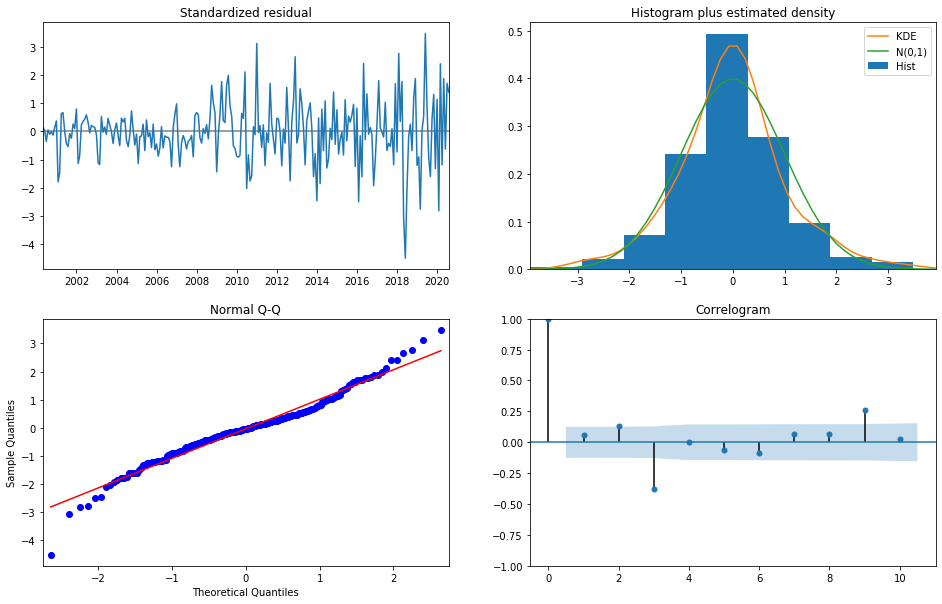

In [34]:
output.plot_diagnostics(figsize=(16,10));

In [26]:
# Plug the optimal parameter values into a new SARIMAX model
SARIMAX_WeHo = sm.tsa.statespace.SARIMAX(WeHo, 
                                        order=(0, 2, 1), 
                                        seasonal_order=(1, 1, 2, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False,
                                        freq='M')

# Fit the model and print results
output = SARIMAX_WeHo.fit()

print(output.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                  295
Model:             SARIMAX(0, 2, 1)x(1, 1, 2, 12)   Log Likelihood               -2411.176
Date:                            Mon, 14 Sep 2020   AIC                           4832.353
Time:                                    17:13:07   BIC                           4850.059
Sample:                                01-31-1996   HQIC                          4839.475
                                     - 07-31-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -3.6880      0.446     -8.263      0.000      -4.563      -2.813
ar.S.L12      -0.2037      0.041   

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


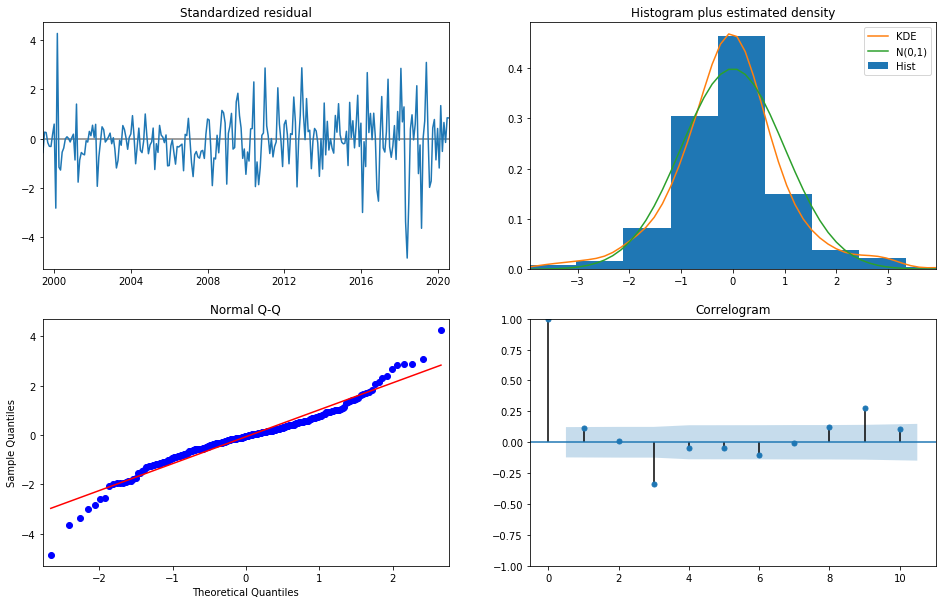

In [27]:
output.plot_diagnostics(figsize=(16,10));

In [35]:
# Get predictions starting from 01-01-1998 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2018-12-31'), dynamic=False)
pred_conf = pred.conf_int()

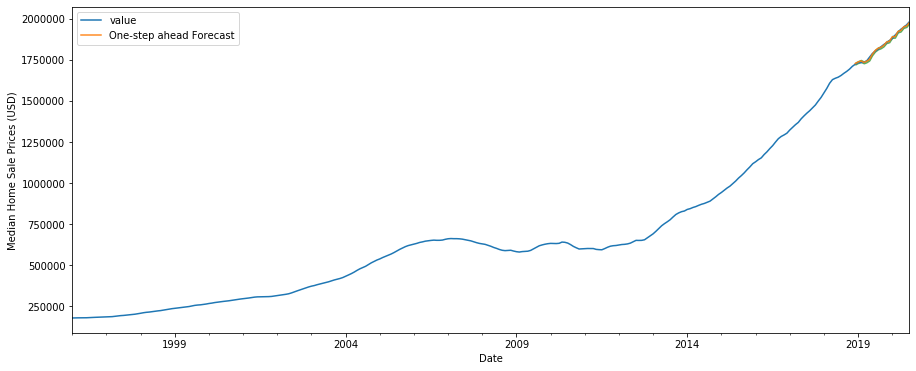

In [36]:
# Plot real vs predicted values along with confidence interval

rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = WeHo['1996':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Median Home Sale Prices (USD)')
plt.legend()

plt.show()

## Calculate RMSE for West Hollywood

In [75]:
from sklearn.metrics import mean_squared_error
import math 

# Get the real and predicted values
WeHo_predicted = pred.predicted_mean
WeHo_real = WeHo['2018-12-31':].value
mse = mean_squared_error(WeHo_real, WeHo_predicted)
rmse = np.sqrt(mse)

# Compute the mean square error
print('The RMSE of our forecasts is {}'.format(round(rmse, 2)))

The RMSE of our forecasts is 6269.53


In [70]:
# Compute the mean square error
mse = ((WeHo_real - WeHo_predicted) ** 2).mean()
rmse = np.sqrt(mse)
print('The RMSE of our forecasts is {}'.format(round(rmse, 2)))

The RMSE of our forecasts is 6269.53


In [76]:
e = []
for i,j in zip(WeHo_real,WeHo_predicted):
    e.append((i-j)**2)

mse = sum(e)/len(e)
rmse = np.sqrt(mse).round(2)
rmse

6269.53

In [38]:
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output.get_prediction(start=pd.to_datetime('2018-12-31'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

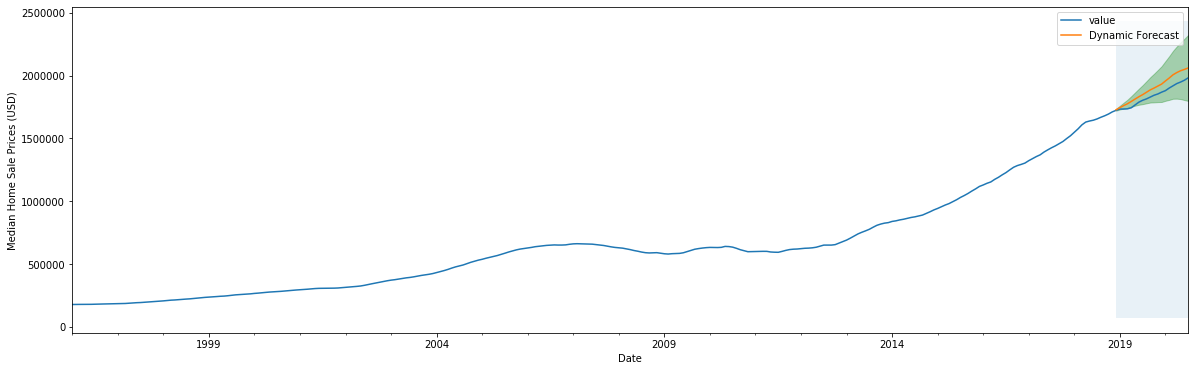

In [39]:
# Plot the dynamic forecast with confidence intervals.

ax = WeHo['1996':].plot(label='observed', figsize=(20, 6))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2018-12-31'), WeHo_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Median Home Sale Prices (USD)')

plt.legend()
plt.show()

# Step 6: Interpreting Results